In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np
import nltk
from nltk.tokenize.casual import casual_tokenize as tokenizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import operator
import re
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from random import randint

# Data import

In [2]:
data = pd.read_csv('Vigiglobe2-1.csv')

In [3]:
# transform timestamp into date

data['date'], data['time'] = data['timestamp'].str.split('T',1).str
data['date'] = pd.to_datetime(data['date'])

# delete observations after the 23.06 : date of Brexit. 
data = data[(data['date'] <= pd.to_datetime('2016-06-23'))]

In [4]:
# assign remain = 0,  leave = 1 , none = 99
data['pos'] = data['Leave_score']

data.loc[data['Leave_score']< 0.85, 'pos'] = 99
data.loc[data['Leave_score'] >= 0.85, 'pos'] = '1'
data.loc[data['Remain_score'] >= 0.85, 'pos'] = '0'

# drop observations that don't have a clear positioning 
# ergo: drop observation with 99 

data = data.drop(data[data.pos == 99].index)

# make column factor
data['pos'] = data['pos'].astype('category')


In [5]:
len(data)

436157

# Data preparation functions

### NLP

In [8]:
# tokenising, removing stopwords, hyperlinks and direct mentions

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
def __cleanText(text):
    global txt, all_words_clean, all_words_clean_og, txt2 
    all_words = []
    txt = []
    for line in text:
        sent = line.lower()
        sent = tknzr.tokenize(sent)
        all_words.extend(sent)
        txt.append(sent)
    stop = list(stopwords.words("english"))
    stop.extend(['...', 'http', 'https', 'rt'])
    all_words_clean = []
    for word in all_words:
        if (word not in stop) and (len(word) >= 2) and (word[0:4]!='http'):
            all_words_clean.append(word)
            
    all_words_clean_og = set(all_words_clean) # all_words_clean: set of all words that appear in corpus; cleaned
    
    txt2 = txt[:] # txt2: list of  tweets. Each sublist is one tweet and each word in the tweet is one seperate string. 
    

# remove all words from tweets that are not in all_words_clean_og
# input: tweets is a list of list of tweets with tokenized words: here txt2
# output: tweets_clean: list of list where each list is one cleaned tweet as one string
def __cleanTweet(tweets): 
    global tweets_clean
    tweets_clean = []
    for i in tweets:
        resultwords  = [word for word in i if word in all_words_clean_og]
        result = ' '.join(resultwords)
        tweets_clean.append([result]) 

#### make word vectors with tf-idf

In [10]:
#clean text and make word vectors with tfidf 
#if tfidf not wanted just leave out code part and use X instead 

def __word_vector_tfidf(all_words_clean, text, txt):
    # all_words_clean: list of all words cleaned 
    # text: list of tweets. for the relevant data make list of 'text' column text = list(data.text).
    # txt: tokneized words list of list
    
    global X_tfidf, tfidf_transformer, X, all_words_clean2

    all_words_clean2 = nltk.FreqDist(all_words_clean)
    word_features = list(all_words_clean2)
    noX = len(text)
    noFeatures = len(word_features)
    X = np.zeros((noX, noFeatures))

    for i in range(noX):
        line = txt[i]
        for j in range(noFeatures):
            word = word_features[j]
            if word in line:
                X[i][j] = 1
                
    # apply tdidf weighting to bag of words word vector  
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X)


#### find the right k for each week

In [386]:
# no need to run it anymore! 

def __find_k(X_tfidf):
    # X_tfidf: sparse weighted word vector matrix from tfidf_transformer

    # k means determine k
    X_tfidf_array = X_tfidf.A   #make sparse matrix an array for plotting
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X_tfidf)

        distortions.append(sum(np.min(cdist(X_tfidf.A, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_tfidf.shape[0])
 
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Optimal k, month:' + month)
    plt.show()

#### Clustering

In [12]:
def __cluster_km(num_clusters, X_tfidf):
    # num_cluster: best number of clusterst based on elbow plot 
    # make the clusters based on the X_tfidf matrix
    global frame, km, clusterkm, clusters, frame_clean
    km = KMeans(n_clusters = num_clusters, random_state = 1)
    km.fit(X_tfidf )

    clusterkm = km.cluster_centers_

    clusters = km.labels_.tolist()

    # adds cluster number to each tweet in data

    frame = pd.DataFrame(text, columns = ['tweet_' + month])
    frame['cluster' + month] = clusters # adds the cluster number to the tweets in the data. 
   
    frame_clean = pd.DataFrame(tweets_clean, columns = ['tweet_' + month])
    frame_clean['cluster' + month] = clusters # same data frame with cluster for each tweet but displays the cleaned tweet. less readible

#### distinct tweets 

In [ ]:
# distinct tweets is a data frame that groups all tweets in the clusters 
# by the tweets and counts their frequency in each cluter
# example: tweet 'hello vote_leave' apprears 5 times and 'vote_leave 4 every' 2 times in cluster 1
# there are 2 distinct tweets in cluster 1

def __distinct_tweets(frame_clean): 

    global distinct_tweets
    distinct_tweets = pd.DataFrame(frame_clean.groupby([('tweet_'+month), ('cluster'+month)]).size().reset_index(name='counts')).sort_values(["cluster"+month, "counts"], ascending = [True, False])

    pd.options.display.max_colwidth = 130
    return distinct_tweets

#### summery of clusters

In [872]:
def __tweets_per_cluster_summary(clusters, frame, km, X_tfidf, month, distinct_tweets, side_month, clusterkm):
    # where km is the model and X_tfidf is a word vector matrix
    # distinct_tweets the df with distinct tweets, cluster and count
    # side_month the origninal data frame for the given month
    # clusterkm = km.cluster_centers_
    # clusters = km.labels_.tolist() list of the cluster number for each tweet
    
    global cluster_summary, summary, cluster_dist, cluster_inertia
    clusters = km.labels_.tolist()
    cluster_df = pd.DataFrame(clusters)
    count = pd.DataFrame({"number_tweets": cluster_df[0].value_counts()}) # number of tweets in each cluster
    unique = frame.groupby('cluster'+month).nunique() # number of different tweets in each cluster
    unique2 = pd.DataFrame(unique.iloc[:,0])
    cluster_summary = pd.merge(count, unique2, left_index=True, right_index=True)
    # summary with number of tweets and number of distinct tweets in each cluster
    
    # now add within-cluster distance (=inertia) for each cluster
    # inertia per cluster
    distances = km.fit_transform(X_tfidf) # Compute clustering and transform X_tfidf to cluster-distance space.
    inertia_df = pd.DataFrame(distances)
    inertia_df['label'] = km.labels_
    inertia_df['dist'] = ""
    for row in range(len(inertia_df)):
        l = inertia_df['label'][row]
        inertia_df.loc[row, 'dist'] = inertia_df[l][row]
    # inertia_df # selects the distance from each point to it's cluster centroid
    cluster_inertia = pd.DataFrame(inertia_df.groupby(['label'])['dist'].sum()) # returns cluster inertia for each cluster
    cluster_summary = pd.merge(cluster_summary, cluster_inertia, left_index=True, right_index=True)
    cluster_summary['cluster'+month] = cluster_summary.index
    cluster_summary = cluster_summary.rename(columns = {'tweet_'+month:'distinct_tweets'})
    # cluster_summary: summary including the number of tweets, number of distinct tweets and the within-cluster distance 
    
    
    
    #cross table with distances between each cluster
    cluster_dist = pd.DataFrame(euclidean_distances(clusterkm))
    cluster_dist['distance_sum'] = cluster_dist.sum(axis = 0)
    



    # only useful if you want to check the dominnat account otherwise irrelevant
    #Find who started the tweet. It's when retweet = 0, or maybe try firts occurence of its type?
    #merge leave_month with cluster info. But now we have to find how often that tweet was retweeted. so we have to find the same tweet with the highest occurence
    # 1. label data frame for tweets where retweet = 0 => know it's the original tweet
    # many NA's as first tweets. Adding the first appearence of a tweet as a OG tweet as well
    # deleting tweets with already retweets => those are tweets from last month! 
    # also: sometimes exact same tweet posted as not-retweet, will still not be in this list
    first_tweet = side_month.sort_values(['text', 'timestamp']).groupby('text').nth(0).reset_index()
    first_tweet['OG'] = 1
    first_tweet.loc[first_tweet['retweets'] >0, 'OG'] = '0'
    first_tweet = first_tweet.rename(columns = {'text': 'tweet_'+month})

    # 2. assign cluster merge with distinct tweets frame
    first_tweet = pd.merge(first_tweet, distinct_tweets, how = 'left', on='tweet_'+month)
    first_tweet = first_tweet.sort_values(['tweet_'+month, 'timestamp'])
    first_tweet = first_tweet[first_tweet["OG"] == 1]
    first_tweet = first_tweet[['screen_name', "tweet_"+month, "cluster"+month, 'counts', "timestamp"]].sort_values('timestamp')
    # calculate the ratio of initial tweets that come from one account
    first_tweet = first_tweet.drop_duplicates('tweet_'+month, keep = "first")
    first_tweet = first_tweet.groupby(['cluster'+month, 'screen_name']).agg({'counts': sum}).reset_index()
    first_tweet = pd.merge(first_tweet, cluster_summary, on = 'cluster'+month)
    first_tweet['ratio'] = first_tweet['counts']/first_tweet['number_tweets']
    summary = pd.DataFrame(first_tweet.sort_values(['cluster'+month, 'ratio'], ascending = [True, False]))
    summary

#### most frequent word in each cluster. not very useful

In [14]:
# creates a dataframe for each cluster
# returns most frequent word in each cluser
# callable with df_dict[0]
# input: data frame with tweets and cluster

def __cluster_topics(frame):
    df = frame.groupby('cluster'+month)
    df_dict = {}
    important = {}
    for key, group in df:
        df_dict[key] = group.reset_index()
        df_dict[key] = df_dict[key].drop(['index'], axis = 1)
        important[key] = pd.DataFrame(Counter(" ".join(df_dict[key]["tweet_" + month]).split()).most_common(100))
    return important


# start from here

In [529]:
# insert leave or remain data leave:1  remain:0
remain = data[data['pos'] == "0"] 
leave = data[data['pos'] == "1"] 
to_print = 'remain' # or leave depending on what you work with
side = remain.copy() # here insert either remain or leave

In [850]:
# has to be run for later code. Pay attention to not run again before completeion of the clustering per side
distinct_tweets_all = pd.DataFrame(columns=['text', 'cluster', 'counts', 'week']) 

### find the right k
based on the elbow plot put the values into the list
select the relevant month. then a random date of one week and plot the elbow plot for every month and mark in the value. 

In [882]:
#here select the month. 01 - 06
month = '02'
side_month = side.loc[side.date.dt.strftime('%m') == month] 

# here select randoms week in that month for finding the best k
side_month = side_month.merge(pd.DataFrame(side_month['date'].dt.week), left_index=True, right_index=True) # add the number of the week
random_week = randint(min(side_month['date_y']), max(side_month['date_y']))
side_week = side_month[side_month['date_y'] == random_week]
# for random week prep data and then run the find k functinon
text = list(side_week.text)
__cleanText(text)
__cleanTweet(txt2)
__word_vector_tfidf(all_words_clean, text, txt)

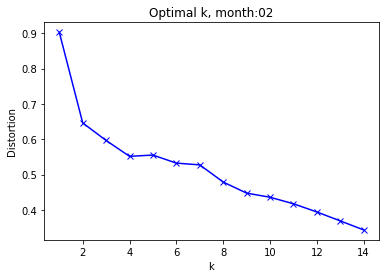

In [883]:
__find_k(X_tfidf)

In [470]:
# here insert in the 'best_k' list the best number of k cluster for each month
best_k_remain = pd.DataFrame({'month': ['01', '02', '03', '04', '05', '06'], 'best_k': [6, 6, 7, 10, 11, 19]})
# june_k_remain: for the last week of june, run a separate elbow plot. way more data in that week need higher k
june_k_remain = 60 
best_k_leave = pd.DataFrame({'month': ['01', '02', '03', '04', '05', '06'], 'best_k': [4, 4, 6, 9, 9, 14]})

In [471]:
# takes the right list of k: best k for leave or remain:
if side['pos'].iloc[0] == "1":
    best_k_side = best_k_leave.copy()
if side['pos'].iloc[0] == "0":
        best_k_side = best_k_remain.copy()

# Weekly clustering 

In [885]:
# select the relevant month for clustering. insert as string
# example: january would be '01'
month = '02'
side_month = side.loc[side.date.dt.strftime('%m') == month] 

In [887]:
cluster_summary_list = []
distinct_tweets_list = []

# loops through each week in the selected month 
# applies first the tweet cleaning, then the clustering and then the summarising for each week

for week in side_month['date'].dt.week.unique():

    this_weeks_data = side_month[side_month['date'].dt.week == week]
    text = list(this_weeks_data.text)

    __cleanText(text)
    __cleanTweet(txt2)
    __word_vector_tfidf(all_words_clean, text, txt)
    
    k = best_k_side.loc[best_k_side['month'] == month, 'best_k'].iloc[0]
    
    if week == 25:  # for the last week of june higher k needed
        k = june_k_remain
    
    __cluster_km(k, X_tfidf)
    __distinct_tweets(frame)
    __tweets_per_cluster_summary(clusters, frame, km, X_tfidf, month, distinct_tweets, side_month, clusterkm)

    labels = km.labels_
    cluster_summary['week'] = week
    distinct_tweets['week'] = week
    cluster_summary_list.append(cluster_summary) # appends all cluster summaries to one pd dataframe
    distinct_tweets_list.append(distinct_tweets)
    print(to_print, ' week:', week)
    display(cluster_summary.sort_values('cluster'+month), distinct_tweets) 
cluster_summary_total = pd.concat(cluster_summary_list, axis=0)
distinct_tweets_total= pd.concat(distinct_tweets_list, axis=0)


remain  week: 5


,number_tweets,distinct_tweets,dist,cluster02,week
0,66,3,43.600269,0,5
1,130,1,0.000000,1,5
2,107,13,83.399535,2,5
3,63,2,42.779180,3,5
4,59,5,46.369568,4,5
5,286,131,278.657847,5,5


,tweet_02,cluster02,counts,week
7,#EURef polling averages by mode - all published surveys since Jan 1 \nONLINE: Remain lead 0.4%\nPHONE: Remain lead 19.5%,0,38,5
97,REMAIN back in lead in latest ICM #EURef online tracker. \nREMAIN 42+1\nLEAVE 39-2\nDK 19,0,19,5
83,LEAVE on 42% to REMAIN 38% in YouGov online #EUref poll. This in sharp contrasts to big REMAIN leads in latest phone polls,0,9,5
131,UK: Majority of remain (green) and leave (red). #London #Scotland and #NorthernIreland want to remain. #EURef,1,130,5
127,Time to put UK first &amp; stop trying to please everone else\n\n#EUdeal #EURef #VoteLeave #Brexit #StrongerIn #VoteRemain,2,29,5
55,Deal or No #EUDeal ?\n\nthe only answer is #Brexit \n\n#EURef #VoteLeave #Brexit #StrongerIn #VoteRemain #LeaveEU,2,22,5
84,Land Rover Defender dies: Production finally halted by EU rules \n\n#EURef #VoteLeave #Brexit #StrongerIn #VoteREMAIN\n,2,22,5
78,Im voting to #LeaveEU \nWhat about you ?\n\n#EURef #VoteLeave #Brexit #StrongerIn #VoteREMAIN,2,7,5
147,Who do you think you are kidding Mr #Cameron ?\n\n#EUdeal #EURef #VoteLeave #Brexit #StrongerIn #VoteREMAIN #LeaveEU,2,7,5
126,Time to #LeaveEU before its too late \n\n#EURef #VoteLeave #Brexit #StrongerIn #VoteREMAIN,2,6,5


remain  week: 6


,number_tweets,distinct_tweets,dist,cluster02,week
0,26,16,23.691783,0,6
1,10,1,0.000000,1,6
2,17,3,12.656295,2,6
3,32,4,22.385652,3,6
4,30,7,25.155571,4,6
5,117,78,114.195473,5,6


,tweet_02,cluster02,counts,week
9,#ThomasTheTankEngine fears #BRexit transport plan @LeShuttle #UK #EU #EUref #INtogether #StrongerIN #BRexit #Remain,0,5,6
21,7 reasons you would miss the EU if the Tories dragged us out of Europe #StrongerIn #Remain #Brexit,0,2,6
69,James Bond would never vote to remain IN\n#strongerin #brexit,0,2,6
80,"Remainers want Brexiteers to reject ""the safest economic option"" (Norway). Why would do what Remainers want? #Brexit",0,2,6
81,Scots want to remain in EU &amp; would vote to leave UK if we Brexit #strongerin #bettertogether,0,2,6
86,"Thatcher might have voted to leave, but Churchill would have voted to remain! #StrongerIn",0,2,6
103,Welcome to twitter @Quakers4Europe! #Remain #In #EUreferendum #Brexit @QCEA @BritishQuakers @QuakerIreland @StrongerIn @Strong...,0,2,6
6,#StrongerIn - 'the uncertainty of #Brexit ' it's obvious we have no idea what remain would look like! #grassrootsout,0,1,6
26,@NachoQuesado @StrongerIn @stuartahutton1 I searched for the Vienna Convention. Can't find shit all. #remain #brexit #strongerIn,0,1,6
46,"But the EU would never dream of trying to harm the City while it and we remain part of the EU, @mjhsinclair #StrongerIn #partn...",0,1,6


remain  week: 7


,number_tweets,distinct_tweets,dist,cluster02,week
0,1635,618,1613.588099,0,7
1,273,7,217.429387,1,7
2,182,4,136.248288,2,7
3,223,5,180.240323,3,7
4,152,6,87.383024,4,7
5,145,2,90.324746,5,7


,tweet_02,cluster02,counts,week
494,Read the actual text of #eudeal here: \n#EUref\n#Brexit\n@euromove\n@StrongerIn\n@labour4europe\n@RemaininEU\n#StrongerIn,0,29,7
604,We need to keep changing the EU so it works better for Britain - but Britain is undoubtedly @StrongerIn #UKinEU,0,27,7
578,UK: Should the United Kingdom remain a member of the European Union or leave the European Union?\n\nRemain: 59% (+12)\nLeave: ...,0,23,7
93,"23rd June #euref there's 363,000 jobs in Yorkshire linked to our trade with the EU @StrongerIn we're #StrongerIn",0,22,7
550,"There are @StrongerIn events going on across the country this weekend, for your nearest event visit #strongerin",0,21,7
279,"For a clean, green future, Britain must remain in the EU. Catch up on my @guardian piece on why we're #StrongerIn",0,20,7
79,.@Dafydd_Wigley appointed to the @StrongerIn board to argue the case for Wales' place in the EU #Plaid16 #StrongerIn,0,19,7
395,Just another reason why I will be voting for us to remain #strongerin the EU !! @WalesStrongerIn @StrongerIn,0,17,7
425,Looks like #EURef will be 23rd June #LabourInForBritain #VoteRemain @NWLabourIN @EuroLabour,0,17,7
412,"Leaving the EU will put jobs, investment&amp; growth at risk. Britain is #StrongerIn",0,16,7


remain  week: 8


,number_tweets,distinct_tweets,dist,cluster02,week
0,178,10,127.088588,0,8
1,287,1,0.000004,1,8
2,152,2,96.594736,2,8
3,99,1,0.000002,3,8
4,144,8,14.403036,4,8
5,2066,818,2038.855195,5,8


,tweet_02,cluster02,counts,week
107,.@DanJarvisMP is clear on the patriotic case for remaining in the EU #StrongerIn,0,67,8
560,Making the patriotic case for Britain remaining in Europe. My piece for @HuffPostUK #LabourInForBritain #euref,0,43,8
298,Alan Johnson on why a vote to remain IN Europe is the patriotic choice #LabourIN #StrongerIn,0,29,8
549,"Like Alan Johnson, I believe a vote to remain in EU is the patriotic choice #StrongerIn #EUreferendum",0,18,8
548,"Like Alan Johnson, I believe a vote to remain in EU is the patriotic choice #StrongerIn #EUreferendum",0,9,8
808,Yesterday I spoke in the House of Commons on #euref about the patriotic case for UK remaining in the EU #StrongerIn,0,4,8
800,"Why remaining in the EU is the proud, patriotic choice. #EuRef #Remain @StrongerIn",0,3,8
299,Alan Johnson on why a vote to remain IN Europe is the patriotic choice #LabourInForBritain #EUref,0,2,8
797,"Why a vote to remain in #Europe is a patriotic vote, by Labour's Alan Johnson: #EUref #StrongerIn #LabourIN",0,2,8
815,_RT_ ChukaUmunna: Alan Johnson on why a vote to remain IN Europe is the patriotic choice #LabourIN #StrongerIn,0,1,8


remain  week: 9


,number_tweets,distinct_tweets,dist,cluster02,week
0,137,1,0.000000,0,9
1,63,7,49.013514,1,9
2,23,3,16.511504,2,9
3,48,6,35.698449,3,9
4,124,78,121.063800,4,9
5,23,2,1.691944,5,9


,tweet_02,cluster02,counts,week
51,How do you intend to vote in the EU referendum? [Please RT] #StrongerIn #LabourInForBritain #UKinEU,0,137,9
15,40 years of being told what we can &amp; can not do is over\n\n#VoteLeave #EUreferendum #StrongerIn #LeaveEU #remain,1,15,9
75,The #EU are stealing OUR fish\n\n#WeWantOurFishBack\n\n#VoteLeave #EUreferendum #StrongerIn #LeaveEU #Brexit #remain,1,14,9
0,#Boris likens the #EU to car journey from Hell\n\n#VoteLeave #EUreferendum #StrongerIn #LeaveEU #BetterOffOut #remain,1,10,9
76,The #EUdeal is not worth the paper its written on...\n\n #VoteLeave #EUreferendum #StrongerIn #LeaveEU #remain #No2EU,1,10,9
32,Another FAILURE c/o the #EuropeanUnion\n\n#VoteLeave #EUreferendum #StrongerIn #LeaveEU #BetterOffOut #remain,1,5,9
60,Lets get out this #EU Prison\n\n#VoteLeave #EUreferendum #StrongerIn #LeaveEU #BetterOffOut #remain,1,5,9
25,@StrongerIn @guardian #ProjectFear from the #Remainians AGAIN ZZZZZZZZZ #BREXIT #VoteLeave #LeaveEU,1,4,9
47,Former Labour Prime Minister Tony Blair on the #EUreferendum #LabourInForBritain #LabourIN #LabourRemain,2,10,9
69,"Our poll closes in a matter of hours, have you added your voice? #StrongerIn #LabourInForBritain #labourremain",2,8,9


### Content inspection of the wrong tweets
If the overview above doesn't show all tweets needed, just insert the cluster for the week wanted and the week number
example: for febraury, week 5 i want to see all tweets in cluster 1

display(distinct_tweets_total[(distinct_tweets_total['cluster'+month] == 1) & (distinct_tweets_total['week'] ==5)].reset_index(drop = True))

In [895]:
display(distinct_tweets_total[(distinct_tweets_total['cluster'+month] == 5) & (distinct_tweets_total['week'] ==5)].reset_index(drop = True))


### Other summary options not used 
There are a few more overviews or tables i didn't use but that might be of interest. They are either called with the following functions or are called in the loop with __tweets_per_cluster_summary and can be accessed with the following: 

1. summary: includes account names of domininat accounts
2. cluster_dist: cross table with distances between all clusters
3. calling __cluster_topics(frame_clean) returns the most frequent words
4. km.inertia_ : total inertia for a cluster 

### Reclassification

In the following, the clusters that you want to be reclassified will be selected. 
When you know for every week in a given month which clusters are wrong and should be reclassified insert in the following. 
It will create a dummy variable for each tweet: "wrong". Every tweet in a cluster that should be reclassified will have wrong = 1 and correctly classified tweets will have wrong = 0.

Sometimes the same tweet will appear over multiple weeks. Not always will the clustering identify that tweet as being wrong in every week. Nevertheless, if it has been classified as wrong in let's say week 2 but not in week 3, it will be marked as being wrong in the data set. Meaning: if a tweet has been identified as wrong once, it will be marked as wrong in the whole data. 

In [851]:
# I will assign the number 1 to the tweets in the cluster that is wrong. the others 0. Then I will merge the dataframe on the tweet
distinct_tweets_total.rename(columns = {'tweet_'+month: 'text', 'cluster'+month: 'cluster'}, inplace = True)
week = list(range(min(distinct_tweets_total['week']), max(distinct_tweets_total['week']) +1)) # list of the weeks

# lets say its march and we have 5 weeks in march: 
# therefore we will have five sublists - one for each week. cluster = [[],[],[],[],[]]
# for each week we identify the wrong clusters. 
# Lets say in week 1 cluster 1 and 2 and in week 3 cluster 0, 4 and 5 are wrong and need to be relcassified. 
# all other weeks don't seem to have any misclassified tweets. their sublists are left empty
# we insert the wrong cluster numbers in the sublist of the respective week. 
# cluster = [[1, 2],[],[0, 4, 5],[],[]]

cluster = [[0, 1, 3],[], [], [], []]# here insert the wrong clusters, pay attention to making subliststs for each week!
distinct_tweets_total['wrong'] = 0
for index, w in enumerate(week):
    for j in cluster[index]:
        distinct_tweets_total.loc[(distinct_tweets_total['week'] == w) & (distinct_tweets_total['cluster'] == j), 'wrong'] = 1


distinct_tweets_all = pd.concat([distinct_tweets_all, distinct_tweets_total])
# distinct_tweets_all is a list of all distinct tweets in that month with a dummy 'wrong'
# if the tweet has been identified as having wrongly been classified by the SVM  
# it will have a 1 and be later reclassified to the other side it actually supports

In [853]:
tt = distinct_tweets_all.sort_values('wrong', ascending = False)
# sort values with wrong first: ascending = False. saying that they were selected therefore better
# sort values with wrong last. not taking any risks
tt = tt.drop_duplicates(subset = 'text', keep = 'first')
# tt data frame contains each tweet and a 1 for wrong and 0 for correct classified
# tweets with wrong == 1 will be reclassified
# new_class merges the original data (side) with the 'wrong' dummy based on the tweet. 
# Meaning, each tweet in the original data will have an indicator if it has been initially wrongly classified 
new_class = side.merge(tt,how='left', left_on='text', right_on='text')


In [200]:
print('number of reclassification: ', sum(new_class['wrong']), 
      'number of distinct reclassifications: ', new_class[new_class['wrong'] == 1]['text'].nunique())

number of reclassification:  13037.0 number of distinct reclassifications:  2842


## merge the data sets
here put the data sets together to create the new ones. But pay attention to the naming of the data frames

In [558]:
# here the tweets that were identified in the clustering as being wrongly clustered are removed from the remain data
true_remain = new_class[new_class['wrong'] == 0]

In [569]:
# writes to excel and keeps OG file
writer = pd.ExcelWriter('output.xlsx')
true_remain.to_excel(writer,'Sheet1')
writer.save()

# need this bc of encoding issues with \r in tweets
true_remain_csv = true_remain.copy()
true_remain_csv['text'] = true_remain_csv['text'].str.replace('\r', ' ')
true_remain_csv.to_csv('mc_true_remain.csv', index = False)

In [509]:
# missing leave will then be merged with the SVM leave data
missing_leave = new_class[new_class['wrong'] == 1]
missing_leave.to_csv('mc_missing_leave.csv')

## merging with SVM leave data 
as there are no wrong classifications with leave we can directly merge the data. Otherwise, the same procedure as for remain has to be performed, but just by naming the files differently

In [722]:
# merge old leave tweets with missing leave tweets
missing_leave.drop(['Unnamed: 0', "cluster", 'counts', "week", "wrong"], inplace=True, axis=1, errors='ignore')
missing_leave['date'], missing_leave['time'] = missing_leave['timestamp'].str.split('T',1).str
missing_leave['date'] = pd.to_datetime(missing_leave['date'])

# here the tweets identified as wrongly classified to remain but are actually leave tweets are added to the original leave data
# this extends the leave data by all the tweetst that were identified in the clusterin as being wrong
true_leave = leave.append(missing_leave) 
true_leave['pos'] = 1
true_leave['date'] = pd.to_datetime(true_leave['date'])
# save as csv
true_leave_csv = true_leave.copy()
true_leave_csv['text'] = true_leave_csv['text'].str.replace('\r', ' ')
true_leave.drop(['cluster','counts', "week", "wrong", "true_wrong"], inplace=True, axis=1, errors='ignore')
true_leave_csv.to_csv('mc_true_leave.csv', index = False)

# EDA 

When using the new data after reclassification, then update the data: 


In [690]:
true_remain.drop(['cluster','counts', "week", "wrong", "true_wrong"], inplace=True, axis=1, errors='ignore')
new_data = true_remain.append(true_leave)[true_remain.columns.tolist()]
new_data['date'], new_data['time'] = new_data['timestamp'].str.split('T',1).str
new_data['date'] = pd.to_datetime(new_data['date'])

#### tweets + retweets per account

In [865]:
new_data.groupby('screen_name')['screen_name'].count().sort_values(ascending = False)

screen_name
iVoteStay          9084
iVoteLeave         3712
AccountantPaul     1430
SimonPhillipsUK    1219
VoteInEU           1215
UKIPNFKN           1061
vote_leave         1040
StrongerInPress     871
Jerryfurmanto       833
EUVoteLeave23rd     670
Woking_IN           636
UkipaLotMoreIan     605
ChrisBaxi           573
AlanJohnson35       571
BritainStrong       562
Gedclegg24          543
JaneKatz27          537
Legal_Poodle        512
margarance          508
marie52d            508
britinfluence       494
SaraPadmore         492
dejavousagain       479
AmszAli             477
GreenBanana4        465
MuppetV2            465
Fight4UK            464
JodieActy           460
SJDelahunty72       449
MikkiL              449
                   ... 
TonyRome51            1
TonySands63           1
TonyScottMusic1       1
TonySlaven            1
TonySloane10          1
TonySmi02283204       1
mcaloonemid           1
TonyStacey            1
TonyThorsen           1
TonyTigerPants7       1
mcal

## Barplots frequency over time

In [876]:
def weekly_barplot (data, timeperiode):
    # for timeperiode put in "month" or "week"
    if timeperiode == 'day':
        p = ''
    if timeperiode == 'month':
        p = '%m'
    if timeperiode == 'week':
        p = '%U'

    ax = data.groupby(['pos', data['date'].dt.strftime(p)])['date'].count().unstack(0).plot.bar(title="Number of tweets reclassification per " + timeperiode, figsize=(14,8))
    _ = ax.set_xlabel(timeperiode)
    _ = ax.set_ylabel('tweet count')
    mylabels = ['remain', 'leave']
    _ = ax.legend(labels=mylabels)
    plt.show()

### reclassifications over time barplot

In [875]:
def reclas_barplot (missing_leave, timeperiode):
    # for timeperiode put in "month" or "week"
    if timeperiode == 'day':
        p = ''
    if timeperiode == 'month':
        p = '%m'
    if timeperiode == 'week':
        p = '%U'

    ax = missing_leave.groupby(['pos', missing_leave['date'].dt.strftime(p)])['date'].count().unstack(0).plot.bar(title="Number of tweets reclassificatied from remain side per " + timeperiode, figsize=(14,8))
    _ = ax.set_xlabel(timeperiode)
    _ = ax.set_ylabel('tweet count')
    mylabels = ['reclassified', 'reclassified']
    _ = ax.legend(labels=mylabels)
    plt.show()

### most frequent hashtags bar plot

In [ ]:
def top_tag(data): # for data you can put the full data set, the specific month etc
    global top_tags, top_tags_df, text_full_data
    text_full_data = list(data["text"])
    top_tags = []
    for tweet in text_full_data:
        tag = re.findall(r"#(\w+)", str(tweet))
        top_tags.append(tag)
    
    top_tags_df = pd.DataFrame(list(Counter(i for i in list(itertools.chain.from_iterable(top_tags))).items()))
    top_tags_df.columns = ['hashtag', "count"]
    top_tags_df = top_tags_df.sort_values('count', ascending = False).reset_index(drop = True)

# frequency chart of most used hashtag 

def plot_tag_occ (data, plot_title): 
    # for plot title insert plot title as string

    top_tag(data)
    counts = dict(Counter(i for i in list(itertools.chain.from_iterable(top_tags))).most_common(15))

    labels, values = zip(*counts.items())

    # sort your values in descending order
    indSort = np.argsort(values)[::-1]
    
    # rearrange your data
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]

    indexes = np.arange(len(labels))

    bar_width = 0.35

    plt.bar(indexes, values)

    # add labels
    plt.xticks(indexes + bar_width, labels, rotation='vertical')
    plt.title(plot_title) # change that title
    plt.show()

#### Count the number of retweets and OG tweets per person

In [831]:
def data_summary(title, data): 
    global tweeter
    dataframe = data.copy()
    total_distinct = dataframe['text'].nunique() # number of distinct tweets across whole data 
    retweets_total = pd.DataFrame(dataframe['text'].value_counts()).reset_index() # count of how often tweet is retweeted/appears
    retweets_total.columns = ['text', 'retweets_total']
    dataframe_n = pd.merge(dataframe, retweets_total, on = "text")
    tweeter = dataframe_n.sort_values(['text', 'timestamp']).groupby('text').nth(0).reset_index()
    tweeter['OG'] = 1
    tweeter.loc[tweeter['retweets'] >0, 'OG'] = '0'
    #tweeter.loc[tweeter['retweets'] == 0, 'OG'] = '1' # here reposts are not counted as retweets. When line deleted then reposts counted as retweets
    tweeter = tweeter[tweeter["OG"] == 1]
    tweeter = pd.DataFrame(tweeter.groupby('screen_name')['retweets_total'].agg(['sum','count']).reset_index())
    # number of posted tweets and their number of retweets, count of the number of tweets
    tweeter.columns = ['screen_name', 'total_retweets', 'first_tweets']
    tweeter['traffic_ratio'] = tweeter['total_retweets']/len(dataframe)
    tweeter['OG_tweets_ratio'] = tweeter['first_tweets']/total_distinct
    tweeter = tweeter.sort_values('total_retweets', ascending = False).reset_index(drop = True)
    print(title)
    display(tweeter)
    #: name, sum of all retweets for original tweets, number of original tweets', "\n", 
    #'traffic_ratio = total_retweets/all tweets posted, OG_tweets_ratio = first_tweets/distinct tweets')
    